In this experiment you will generate traffic using tcpreplay and capture it with DAG.  
###### Setup:  
-- `rmmod ixgbe && modprobe ixgbe allow_supported_sfp=1`   
-- `ifconfig intl0 up && ifconfig intl1 up` (Machine B)  
-- `ifconfig slf0 up` (Machine A)  
-- `ssh-add` (Machine A)  
-- `dagload`  (Machine A)  
-- Connect intl0 (B) to dag0 (A).       
-- Connect intl1 (B) to slf0 (A).       
<img src="alt_setup3.2.jpg">

tcpreplay takes a pcap file along with other parameters, to determine how to replay traffic.

###### Usage:   
`tcpreplay -i <interface> -l <replay number> --preload-pcap [Optional: -t] [Optional: -p <packets/sec>] blah.pcap`  
NB -t means max speed and is not to be used in conjuction with -p.  
  
Eg. Replay blah.pcap 20 times on intl1, at 20000 packets/sec.  
`tcpreplay -i intl1 -l 20 --preload-pcap -p 20000 blah.pcap`

In [1]:
crsid='jlf60'
%run /root/$crsid/L50/Jupyter/useful/useful.py
% run /root/$crsid/L50/Jupyter/useful/useful3.py
%matplotlib inline
machB_ip = '128.232.82.64' # REPLACE THIS

The function `send` will be used throughout this Notebook:  
Generate traffic from the NIC (Machine B) using tcpreplay. Traffic to the DAG card (Machine A) is captured to a .erf file. One summary line for each packet received is written to a .txt file. Check that these are correctly saved to L50Lab3/3.2.   


In [2]:
def send(exp,size,num,pps=0):
    # size = packet size in bytes
    # num = no of packets to send
    # pps = sending rate in packets/sec
    
    dag_cmd = shlex.split('dagsnap -d0 -o /root/'+crsid+'/L50Lab3/3.2/'+exp+'.erf')
    p = Popen(dag_cmd) # start capture
    sleep(2)
    pps_cmd = ' -t'
    if (pps != 0):
        pps_cmd = ' -p ' + str(pps)
    play_cmd = ('tcpreplay -i intl0 -l '+str(num)+pps_cmd+' --preload-pcap '
                '/root/'+crsid+'/L50/pcap_files/'+str(size)+'.cap')
    ssh = ssh_connect(machB_ip)
    ssh_cmd(play_cmd, ssh) # generate traffic
    sleep(2)
    ssh.close()
    p.kill() # end capture
    sleep(2)
    local_cmd('tshark -r /root/'+crsid+'/L50Lab3/3.2/'+exp+'.erf > /root/'+crsid+'/L50Lab3/3.2/'+exp+'.txt') # write summary lines

## Experiment a

Send 1000 packets, size 512B. See that all the packets arrive.

In [45]:
send('exp2a',512,1000)

In [46]:
num_pkts = sum(1 for line in open('/root/'+crsid+'/L50Lab3/3.2/exp2a.txt') if line)
print "Packets received: " + str(num_pkts)

Packets received: 1000


## Experiment b

Send 100000 packets, size 512B. See that all the packets arrive. What is the captured packet rate?

In [47]:
send('exp2b',512,10000)

In [48]:
num_pkts = sum(1 for line in open('/root/'+crsid+'/L50Lab3/3.2/exp2b.txt') if line)
print "Packets received: " + str(num_pkts)

deltas = getdeltas('3.2/exp2b',crsid,10000)
pps = int(floor(1.0 / np.average(deltas) * 1000000))
print "Packets per second: " + str(pps)

Packets received: 10000
Packets per second: 283120


## Experiment c

Send 10000 packets, size 1024B / 512B / 64B. What is the maximum packet rate supported by the tool? what is the  bandwidth? What is the effect of line coding (64b/66b)?

Bandwidth and packet rate reduce as packet size reduces this is due to some overhead (probably reading from disk) increases as packet size reduces. This means bandwidth is limited by the tool rather than the link

In [49]:
def rate(exp,size,num):
    deltas = getdeltas(exp,crsid,num)
    rt = (size+20+4)*8/ np.average(deltas)
    pps = int(floor(1.0 / np.average(deltas) * 1000000))
    print "Packets per second: " + str(pps)
    print "BW: " + str(rt) + " Mbits/sec" 

### 1024B

In [70]:
send('exp2c1',1024,10000)

In [71]:
rate('3.2/exp2c1',1024,10000)

Packets per second: 255452
BW: 2141.714323554244 Mbits/sec


### 512B

In [72]:
send('exp2c2',512,10000)

In [73]:
rate('3.2/exp2c2',512,10000)

Packets per second: 264013
BW: 1132.0901064862578 Mbits/sec


### 64B

In [68]:
send('exp2c3',64,10000)

In [69]:
rate('3.2/exp2c3',64,10000)

Packets per second: 270784
BW: 190.63254956021223 Mbits/sec


## Experiment d

Send 10000 packets, size 512B, 100 Mbits/sec (ignore line coding). What is the measured traffic throughput?

In [74]:
pps = 100000000 / ((512+4)*8)
print("Packets per Second: " + str(pps))
bw = ((512+4+20)* 8* pps) / 1000000.0
print "Expected bandwidth: " + str(bw) + " Mbits/sec"
send('exp2d',512,10000,pps)

Packets per Second: 24224
Expected bandwidth: 103.872512 Mbits/sec


In [75]:
rate('3.2/exp2d',512,10000)

Packets per second: 21190
BW: 90.86672406932256 Mbits/sec


## Experiment e

What is the distribution of inter-arrival time of experiment d?

Plot the CDF of inter-arrival time.

Mean: 47.1899921992
Median: 47.016
Variance: 3.98446370508


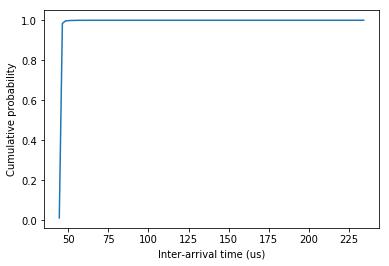

In [89]:
import statistics
deltas = getdeltas('3.2/exp2d', crsid,10000)
print("Mean: " + str(statistics.mean(deltas)))
print("Median: " + str(statistics.median(deltas)))
print("Variance: " + str(statistics.variance(deltas)))
values, base = np.histogram(deltas, bins=100)
cumulative = np.cumsum(values/9999.0)
plt.plot(base[:-1], cumulative)
plt.ylabel("Cumulative probability")
plt.xlabel("Inter-arrival time (us)")
plt.show()

Number of values removed: 1


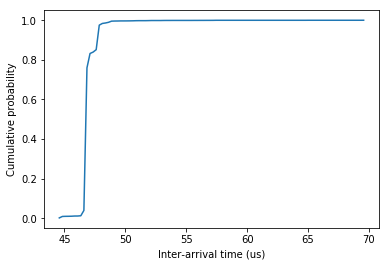

In [79]:
clipped_deltas = list(filter(lambda x: x<200, deltas))
print("Number of values removed: " + str(len(deltas) - len(clipped_deltas)))
values, base = np.histogram(clipped_deltas, bins=100)
cumulative = np.cumsum(values/9999.0)
plt.plot(base[:-1], cumulative)
plt.ylabel("Cumulative probability")
plt.xlabel("Inter-arrival time (us)")
plt.show()

## Experiment f

Send 10000 packets, size 512B, intl0 (B) to dag0 (A), intl1  (B) to slf0 (A), 100 Mbits/sec. What is the distribution of inter-arrival time?

In [14]:
%%capture
dag_cmd = shlex.split('dagsnap -d0 -o /root/'+crsid+'/L50Lab3/3.2/exp2f.erf')
p = Popen(dag_cmd) # start capture

sleep(2)

play_cmd1 = ('tcpreplay -i intl0 -l 10000 -p '+str(pps)+' --preload-pcap '
            '/root/'+crsid+'/L50/pcap_files/512.cap')
play_cmd2 = ('tcpreplay -i intl1 -l 10000 -p '+str(pps)+' --preload-pcap '
            '/root/'+crsid+'/L50/pcap_files/512.cap')
ssh = ssh_connect(machB_ip)
start_new_thread(ssh_cmd,(play_cmd1,ssh)) # generate traffic
start_new_thread(ssh_cmd,(play_cmd2,ssh)) # generate traffic

sleep(10)

ssh.close()
p.kill() # end capture
sleep(2)

Plot the CDF of inter-arrival time.

Mean: 47.2026414641
Median: 47.028
Variance: 3.61275604017


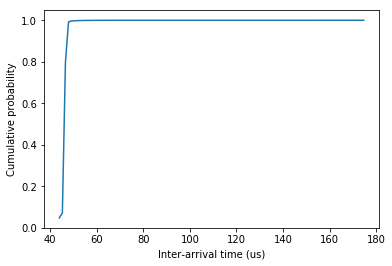

In [90]:
deltas2 = getdeltas('3.2/exp2f',crsid, 10000)
print("Mean: " + str(statistics.mean(deltas2)))
print("Median: " + str(statistics.median(deltas2)))
print("Variance: " + str(statistics.variance(deltas2)))
values, base = np.histogram(deltas2, bins=100)
cumulative = np.cumsum(values/9999.0)
plt.plot(base[:-1], cumulative)
plt.ylabel("Cumulative probability")
plt.xlabel("Inter-arrival time (us)")
plt.show()

Number of values removed: 2


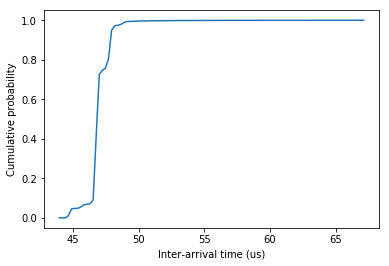

In [80]:
clipped_deltas2 = list(filter(lambda x: x<100, deltas2))
print("Number of values removed: " + str(len(deltas2) - len(clipped_deltas2)))
values, base = np.histogram(clipped_deltas2, bins=100)
cumulative = np.cumsum(values/9999.0)
plt.plot(base[:-1], cumulative)
plt.ylabel("Cumulative probability")
plt.xlabel("Inter-arrival time (us)")
plt.show()